In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sb  
import random
%matplotlib inline

In [2]:
file_path = 'data/gapminder_under5mortality.csv'
child_mortality_df = pd.read_csv(file_path, index_col = 0)
child_mortality_df.index.names = ['country']

child_mortality_df.shape

(440, 216)

In [3]:
child_mortality_df.head()



,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
country,,,,,,,,,,,,,,,,,,,,,
Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,116.3,113.2,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1
Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,19.5,18.7,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,32.1,30.7,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0


Clean data, remove countiry with missing or no information.

In [4]:
child_mortality_clean = child_mortality_df.dropna()
#child_mortality_clean = child_mortality_clean.drop(child_mortality_clean.columns[[i for i in range(0,100)]], axis=1)  # df.columns is zero-based pd.Index 


In [5]:
child_mortality_clean.head()

,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,116.3,113.2,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,19.5,18.7,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,32.1,30.7,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0
Angola,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,...,200.5,196.4,192.0,187.3,182.5,177.3,172.2,167.1,162.2,156.9
Antigua and Barbuda,473.60,469.77,465.97,462.20,458.47,454.76,451.08,447.43,443.82,440.23,...,11.8,11.3,10.9,10.4,9.9,9.5,9.1,8.7,8.4,8.1


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

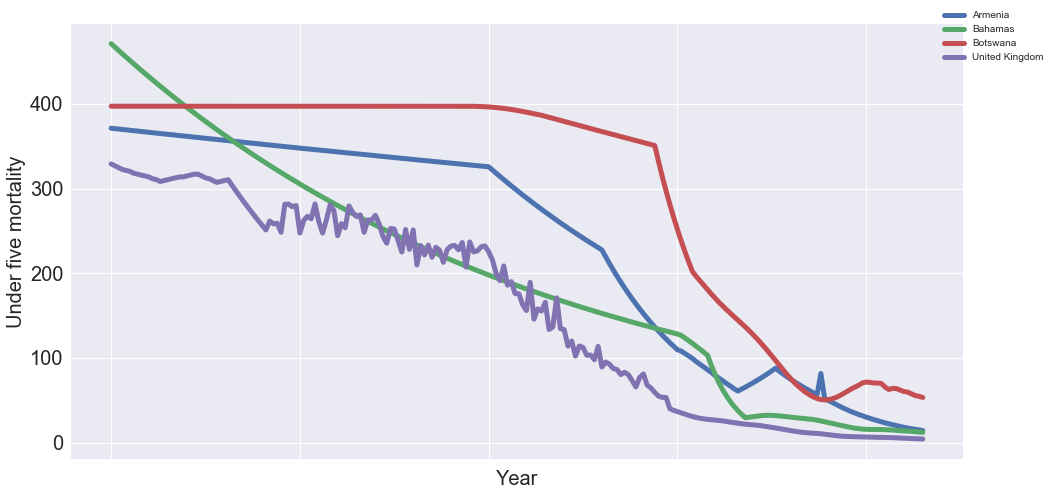

In [7]:
labels = []


fig = plt.figure()
ax = plt.subplot(111)
for i in range(child_mortality_clean.shape[0]):
    plot = random.randint(0, 100)
    if plot<3:
        child_mortality_clean.iloc[i].plot(x=child_mortality_clean.axes[1],figsize=(16,8), linewidth=5, fontsize=20)
        labels.append(child_mortality_clean.index[i])
    plt.legend(labels);
plt.xlabel('Year', fontsize=20);
plt.ylabel('Under five mortality', fontsize=20);

ax.legend(bbox_to_anchor=(1.1, 1.05))


Implementing PCA

In [8]:
from  sklearn.decomposition  import PCA

pca = PCA(n_components=4)
pca.fit(child_mortality_clean)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [9]:
child_mortality_4D = pca.transform(child_mortality_clean)
print(pca.explained_variance_ratio_)

[0.76831065 0.12479226 0.03627298 0.02262252]


In [10]:
child_mortality_PC_df = pd.DataFrame(child_mortality_4D)
child_mortality_PC_df.index = child_mortality_clean.index
child_mortality_PC_df.columns = ['PC1','PC2','PC3','PC4']
child_mortality_PC_df.head()

,PC1,PC2,PC3,PC4
country,,,,
Afghanistan,-1640.962019,-433.084866,113.775000,46.322522
Albania,275.775641,80.866800,-277.642172,-160.617319
Algeria,-914.671217,132.754213,-51.810449,131.642385
Angola,-1658.840597,-405.102842,293.550760,-56.821857
Antigua and Barbuda,1481.556193,-354.894205,69.464114,340.838996


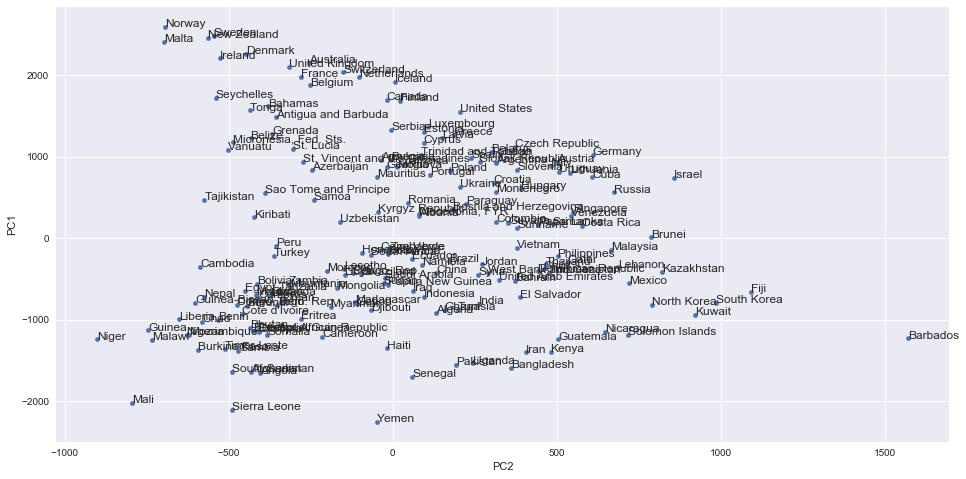

In [11]:
ax = child_mortality_PC_df.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, country in enumerate(child_mortality_PC_df.index):
    ax.annotate(country, (child_mortality_PC_df.iloc[i].PC2, child_mortality_PC_df.iloc[i].PC1))

In [12]:
from sklearn.preprocessing import normalize

child_mortality_PC_df['country_mean'] = pd.Series(child_mortality_clean.mean(axis=1), index=child_mortality_clean.index)
country_mean_max = child_mortality_PC_df['country_mean'].max()
country_mean_min = child_mortality_PC_df['country_mean'].min()
country_mean_scaled = (child_mortality_PC_df.country_mean-country_mean_min) / country_mean_max
child_mortality_PC_df['country_mean_scaled'] = pd.Series(country_mean_scaled, index=child_mortality_clean.index)
child_mortality_PC_df.head()

,PC1,PC2,PC3,PC4,country_mean,country_mean_scaled
country,,,,,,
Afghanistan,-1640.962019,-433.084866,113.775000,46.322522,400.369907,0.622810
Albania,275.775641,80.866800,-277.642172,-160.617319,270.369120,0.327422
Algeria,-914.671217,132.754213,-51.810449,131.642385,350.462222,0.509410
Angola,-1658.840597,-405.102842,293.550760,-56.821857,408.963935,0.642338
Antigua and Barbuda,1481.556193,-354.894205,69.464114,340.838996,204.621065,0.178029


In [13]:
child_mortality_PC_df['country_change'] = pd.Series(child_mortality_clean['1800']-child_mortality_clean['2015'], index=child_mortality_clean.index)
country_change_max = child_mortality_PC_df['country_change'].max()
country_change_min = child_mortality_PC_df['country_change'].min()
country_change_scaled = (child_mortality_PC_df.country_change - country_change_min) / country_change_max
child_mortality_PC_df['country_change_scaled'] = pd.Series(country_change_scaled, index=child_mortality_PC_df.index)
child_mortality_PC_df[['country_change','country_change_scaled']].head()

,country_change,country_change_scaled
country,,
Afghanistan,377.48,0.168827
Albania,361.20,0.136258
Algeria,436.21,0.286320
Angola,328.78,0.071400
Antigua and Barbuda,465.50,0.344917


In [14]:
child_mortality_PC_df['country_change_slope'] = pd.Series((child_mortality_clean['1900']-child_mortality_clean['2000'])/float(2015-1900), index=child_mortality_clean.index)
country_change_max = child_mortality_PC_df['country_change_slope'].max()
country_change_min = child_mortality_PC_df['country_change_slope'].min()
country_change_scaled = (child_mortality_PC_df.country_change_slope - country_change_min) / country_change_max
child_mortality_PC_df['country_change_slope_scaled'] = pd.Series(country_change_scaled, index=child_mortality_PC_df.index)
child_mortality_PC_df[['country_change_slope_scaled','country_change_slope']].head()

,country_change_slope_scaled,country_change_slope
country,,
Afghanistan,0.379062,2.998000
Albania,0.384311,3.027739
Algeria,0.493776,3.647913
Angola,0.261124,2.329826
Antigua and Barbuda,0.148850,1.693739


In [15]:
child_mortality_PC_df['country_max'] = pd.Series(child_mortality_clean['1800'])
country_mean_max = child_mortality_PC_df['country_max'].max()
country_mean_min = child_mortality_PC_df['country_max'].min()
country_mean_scaled = (child_mortality_PC_df.country_max-country_mean_min) / country_mean_max
child_mortality_PC_df['country_max_scaled'] = pd.Series(country_mean_scaled, index=child_mortality_clean.index)
child_mortality_PC_df.head()

,PC1,PC2,PC3,PC4,country_mean,country_mean_scaled,country_change,country_change_scaled,country_change_slope,country_change_slope_scaled,country_max,country_max_scaled
country,,,,,,,,,,,,
Afghanistan,-1640.962019,-433.084866,113.775000,46.322522,400.369907,0.622810,377.48,0.168827,2.998000,0.379062,468.58,0.270483
Albania,275.775641,80.866800,-277.642172,-160.617319,270.369120,0.327422,361.20,0.136258,3.027739,0.384311,375.20,0.097698
Algeria,-914.671217,132.754213,-51.810449,131.642385,350.462222,0.509410,436.21,0.286320,3.647913,0.493776,460.21,0.254996
Angola,-1658.840597,-405.102842,293.550760,-56.821857,408.963935,0.642338,328.78,0.071400,2.329826,0.261124,485.68,0.302124
Antigua and Barbuda,1481.556193,-354.894205,69.464114,340.838996,204.621065,0.178029,465.50,0.344917,1.693739,0.148850,473.60,0.279772


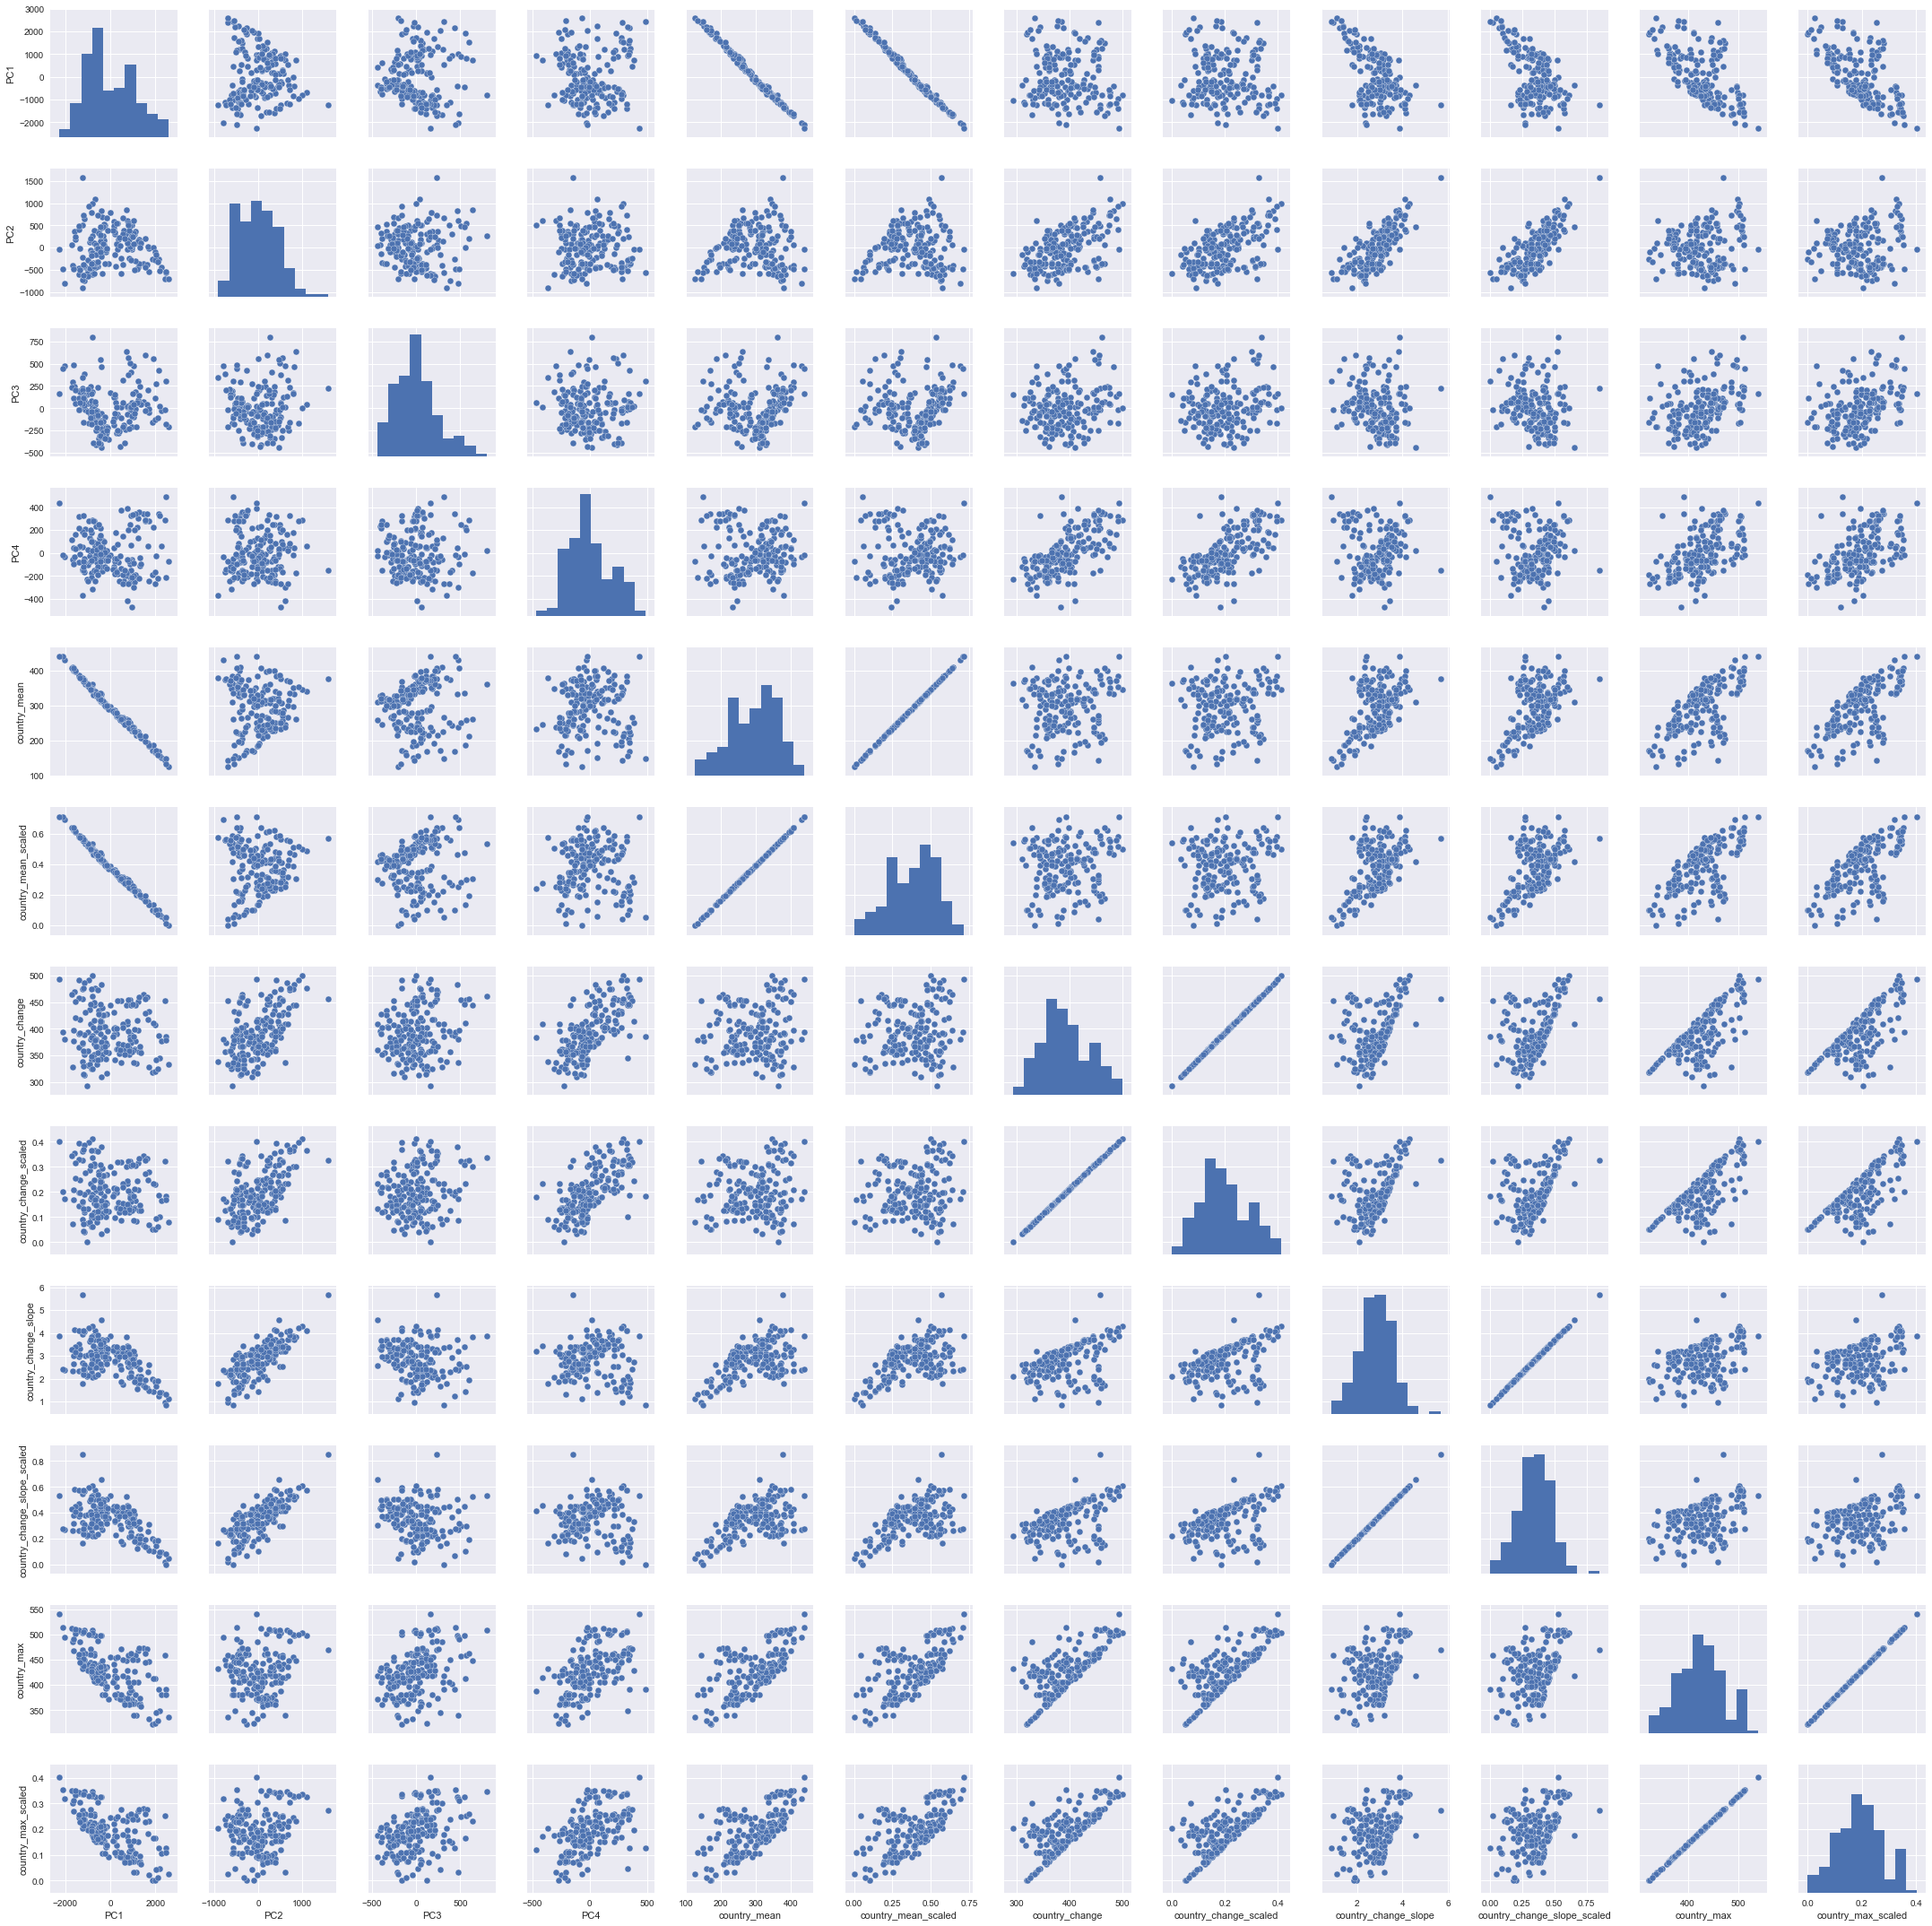

In [16]:
seaborn.pairplot(child_mortality_PC_df)

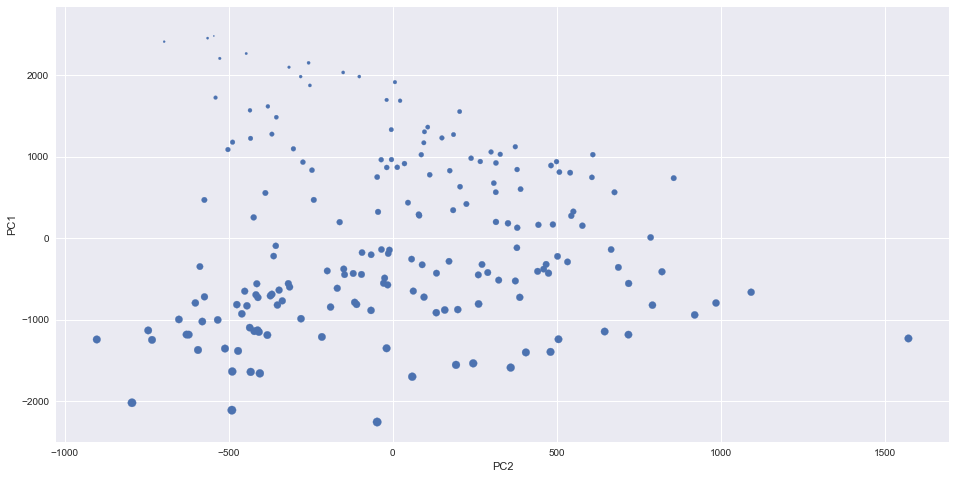

In [17]:
child_mortality_PC_df.plot(kind='scatter', x='PC2', y='PC1', s=child_mortality_PC_df['country_mean_scaled']*100, figsize=(16,8))

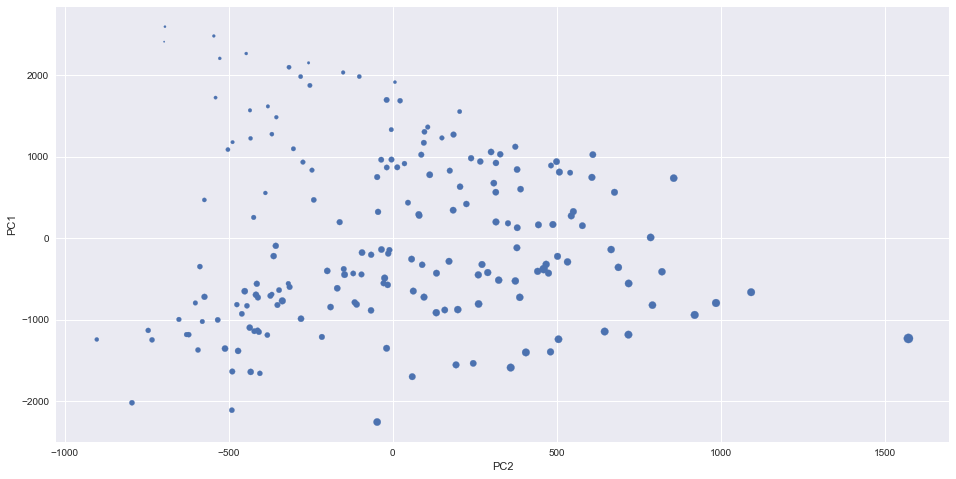

In [18]:
child_mortality_PC_df.plot(kind='scatter', x='PC2', y='PC1', s=child_mortality_PC_df['country_change_slope_scaled']*100, figsize=(16,8))

In [19]:
from  sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)

clusters = kmeans.fit(child_mortality_PC_df[['PC1','PC2','PC3','PC4']])

In [20]:
child_mortality_PC_df['cluster'] = pd.Series(clusters.labels_, index=child_mortality_PC_df.index)
child_mortality_clean['cluster'] = pd.Series(clusters.labels_, index=child_mortality_clean.index)

child_mortality_clean.head()

/Users/camilarangelsmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,cluster
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,113.2,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1,0
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,18.7,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0,1
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,30.7,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0,2
Angola,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,...,196.4,192.0,187.3,182.5,177.3,172.2,167.1,162.2,156.9,0
Antigua and Barbuda,473.60,469.77,465.97,462.20,458.47,454.76,451.08,447.43,443.82,440.23,...,11.3,10.9,10.4,9.9,9.5,9.1,8.7,8.4,8.1,3


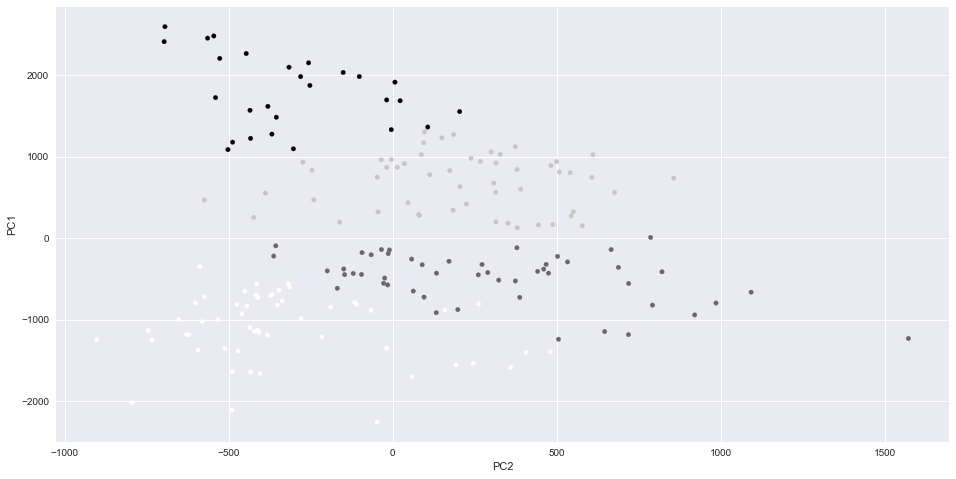

In [21]:
import numpy as np

child_mortality_PC_df.plot(
    kind='scatter',
    x='PC2',y='PC1',
    c=child_mortality_PC_df.cluster.astype(np.float), 
    figsize=(16,8))

In [22]:
child_mortality_PC_df_cluster0= child_mortality_clean[child_mortality_clean['cluster']==0]
child_mortality_PC_df_cluster1= child_mortality_clean[child_mortality_clean['cluster']==1]
child_mortality_PC_df_cluster2= child_mortality_clean[child_mortality_clean['cluster']==2]
child_mortality_PC_df_cluster3= child_mortality_clean[child_mortality_clean['cluster']==3]
child_mortality_PC_df_cluster4= child_mortality_clean[child_mortality_clean['cluster']==4]



In [23]:
def timeseries_for_countries(selected_countries):

    labels = []

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(selected_countries.shape[0]):
        
        selected_countries.iloc[i].plot(x=selected_countries.axes[1],figsize=(16,8), linewidth=3, fontsize=20)
        labels.append(selected_countries.index[i])
        plt.legend(labels);
    ax.legend(bbox_to_anchor=(1.1, 1.05))

In [24]:
def timeseries_for_countries_mean(cluster_df):
    cluster_df.loc['mean'] = cluster_df.mean()
    cluster_df.iloc[-1].plot(x=cluster_df.axes[1],figsize=(16,8), linewidth=5, fontsize=20)



/Users/camilarangelsmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


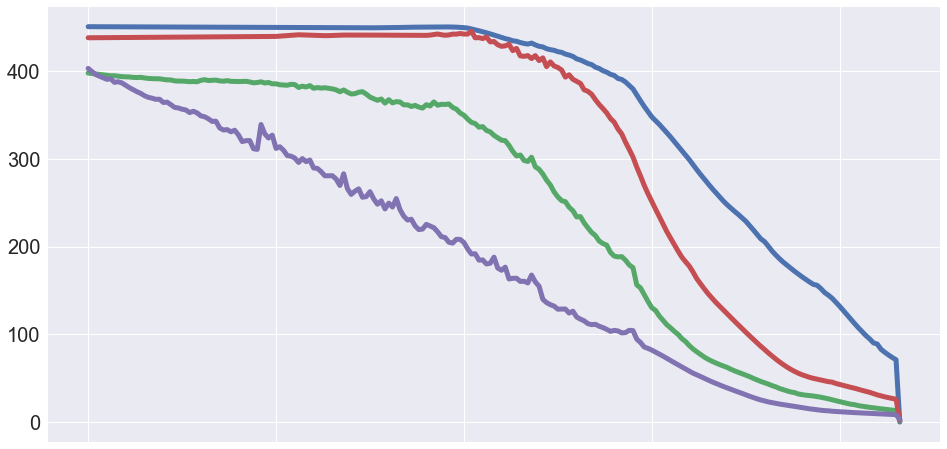

In [25]:
timeseries_for_countries_mean(child_mortality_PC_df_cluster0)
timeseries_for_countries_mean(child_mortality_PC_df_cluster1)
timeseries_for_countries_mean(child_mortality_PC_df_cluster2)
timeseries_for_countries_mean(child_mortality_PC_df_cluster3)
timeseries_for_countries_mean(child_mortality_PC_df_cluster4)

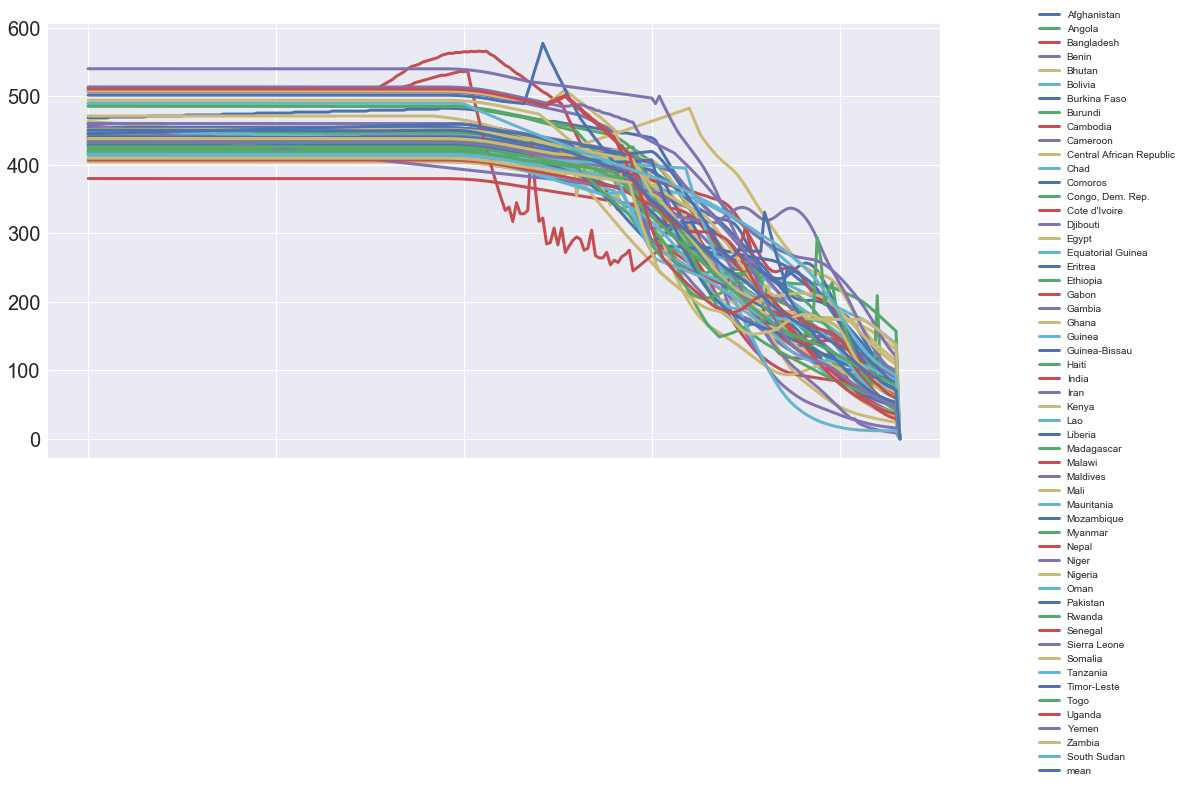

In [26]:
timeseries_for_countries(child_mortality_PC_df_cluster0)

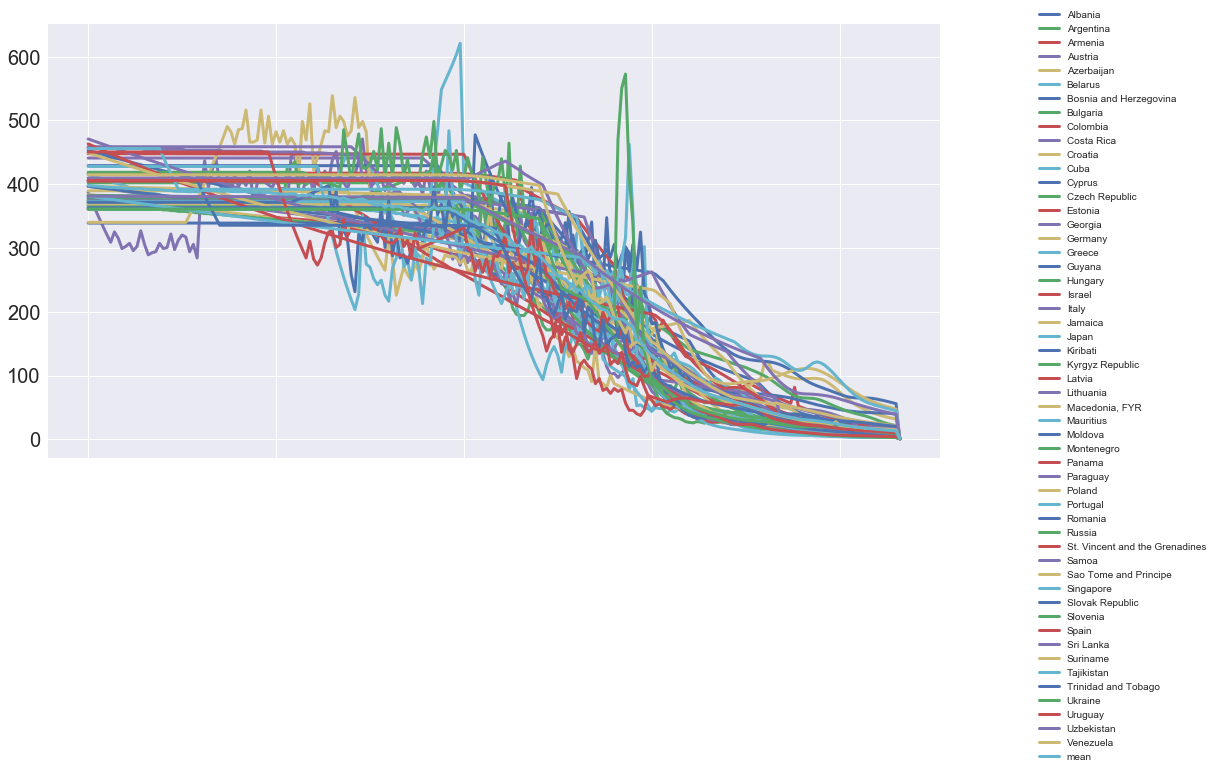

In [27]:
timeseries_for_countries(child_mortality_PC_df_cluster1)

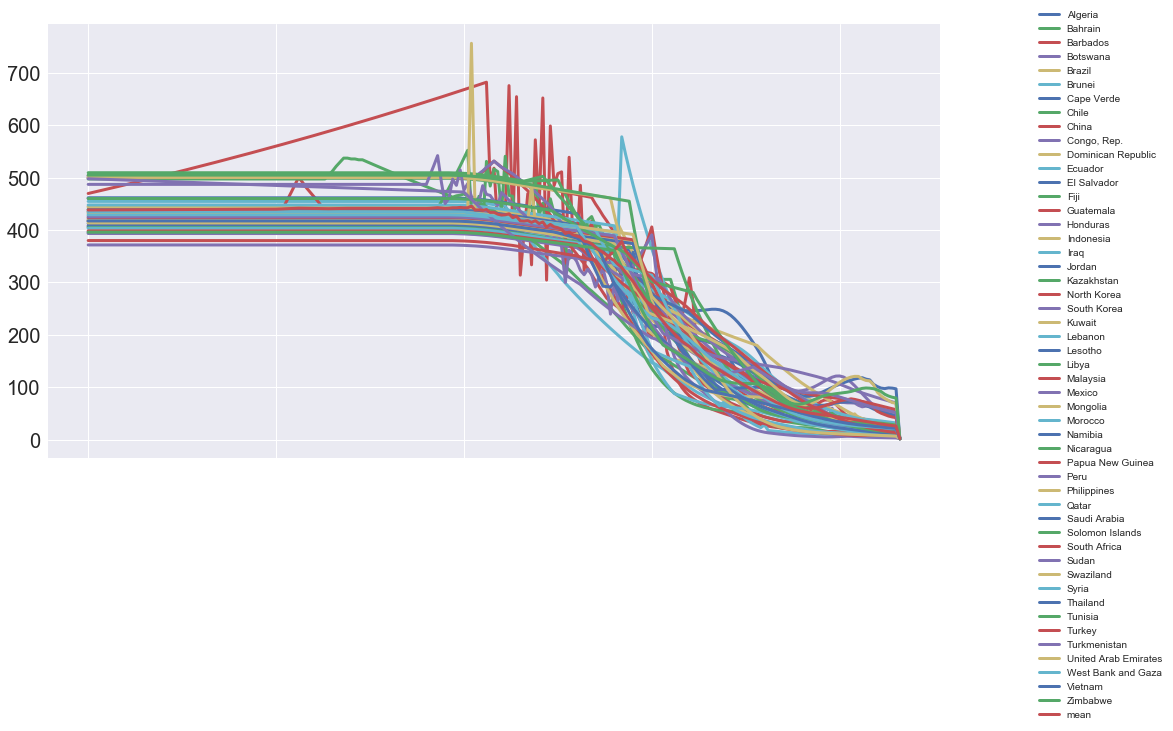

In [28]:
timeseries_for_countries(child_mortality_PC_df_cluster2)

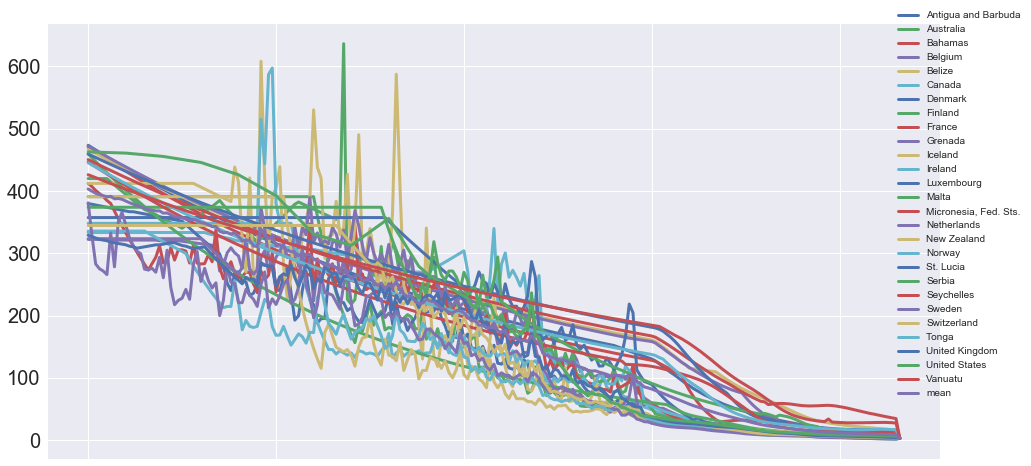

In [29]:
timeseries_for_countries(child_mortality_PC_df_cluster3)

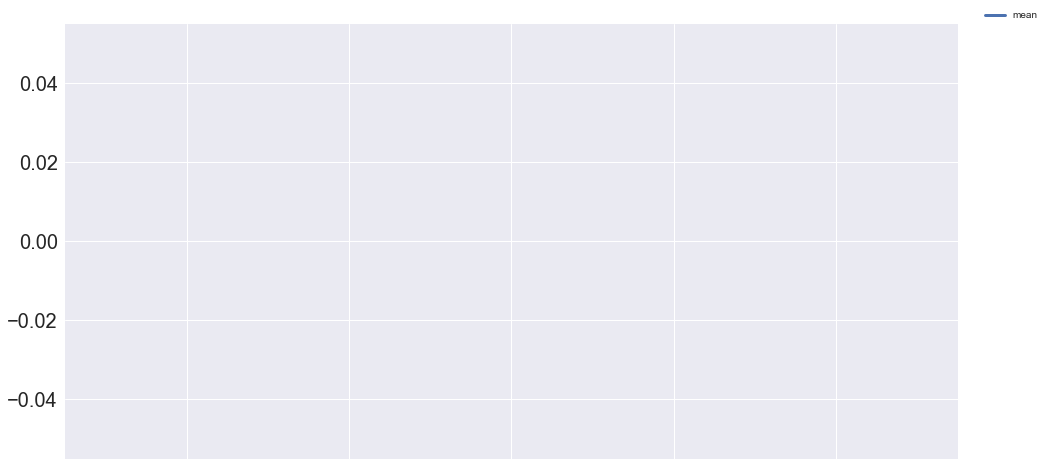

In [30]:
timeseries_for_countries(child_mortality_PC_df_cluster4)

Relate this to income:

In [31]:
file_path = 'data/gapminder_gdp_per_capita.csv'
gdp_per_capita_df = pd.read_csv(file_path, index_col = 0)

gdp_per_capita_df.shape
gdp_per_capita_df.reset_index(level=0, inplace=True)


In [32]:
gdp_per_capita_df_clean = gdp_per_capita_df.dropna()
gdp_per_capita_df_clean.head()

,GDP per capita,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
1,Afghanistan,603.0,603.0,603.0,603.0,603.0,603.0,603.0,603.0,603.0,...,1173.0,1298.0,1311.0,1548.0,1637.0,1695.0,1893.0,1884.0,1877.0,1925.0
3,Albania,667.0,667.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,...,7476.0,7977.0,8644.0,8994.0,9374.0,9640.0,9811.0,9961.0,10160.0,10620.0
4,Algeria,716.0,716.0,717.0,718.0,719.0,720.0,721.0,722.0,723.0,...,12088.0,12289.0,12314.0,12285.0,12494.0,12606.0,12779.0,12893.0,13179.0,13434.0
6,Andorra,1197.0,1199.0,1201.0,1204.0,1206.0,1208.0,1210.0,1212.0,1215.0,...,42738.0,43442.0,41426.0,41735.0,38982.0,41958.0,41926.0,43735.0,44929.0,46577.0
7,Angola,618.0,620.0,623.0,626.0,628.0,631.0,634.0,637.0,640.0,...,5445.0,6453.0,7103.0,7039.0,7047.0,7094.0,7230.0,7488.0,7546.0,7615.0


In [33]:
gdp_list = []
for i in range(child_mortality_clean.shape[0]):
    
    name =  child_mortality_clean.index[i]
    try:    
        gdp = float(gdp_per_capita_df_clean[gdp_per_capita_df_clean['GDP per capita']==name]['2015'])
    except Exception:
        print name
        gdp = np.nan
    gdp_list.append(gdp)
    
child_mortality_clean['GDP']= gdp_list

Croatia


/Users/camilarangelsmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [ ]:
child_mortality_clean = child_mortality_clean.dropna()

child_mortality_clean

,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2008,2009,2010,2011,2012,2013,2014,2015,cluster,GDP
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,468.58,468.58,468.58,468.58,468.58,468.58,469.98,469.98,469.98,469.98,...,110.4,107.6,105.0,102.3,99.5,96.7,93.9,91.1,0,1925.0
Albania,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,375.20,...,17.9,17.3,16.6,16.0,15.5,14.9,14.4,14.0,1,10620.0
Algeria,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,460.21,...,29.5,28.4,27.4,26.6,25.8,25.2,24.6,24.0,2,13434.0
Angola,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,485.68,...,192.0,187.3,182.5,177.3,172.2,167.1,162.2,156.9,0,7615.0
Antigua and Barbuda,473.60,469.77,465.97,462.20,458.47,454.76,451.08,447.43,443.82,440.23,...,10.9,10.4,9.9,9.5,9.1,8.7,8.4,8.1,3,21049.0
Argentina,402.19,402.19,402.19,402.19,402.19,402.19,402.19,402.19,402.19,402.19,...,15.4,15.0,14.6,14.2,13.8,13.3,12.9,12.5,1,17344.0
Armenia,371.20,370.71,370.23,369.75,369.26,368.78,368.30,367.82,367.34,366.86,...,20.0,19.0,18.0,17.2,16.3,15.5,14.9,14.2,1,7763.0
Australia,390.99,390.99,390.99,390.99,390.99,390.99,390.99,390.99,390.99,390.99,...,5.2,5.0,4.8,4.5,4.2,4.0,3.7,3.5,3,44056.0
Austria,387.32,373.01,359.22,345.95,333.16,320.85,308.99,325.26,315.50,299.15,...,4.6,4.5,4.4,4.2,4.0,3.9,3.7,3.5,1,44401.0


In [ ]:
sb.distplot(child_mortality_clean[child_mortality_clean['cluster']==1]['GDP'],kde=False);
sb.distplot(child_mortality_clean[child_mortality_clean['cluster']==0]['GDP'],kde=False);
sb.distplot(child_mortality_clean[child_mortality_clean['cluster']==3]['GDP'],kde=False);
sb.distplot(child_mortality_clean[child_mortality_clean['cluster']==2]['GDP'],kde=False);



In [ ]:
print child_mortality_clean[child_mortality_clean['cluster']==0]['GDP'].mean()
print child_mortality_clean[child_mortality_clean['cluster']==0].index

In [ ]:
print child_mortality_clean[child_mortality_clean['cluster']==1]['GDP'].mean()
print child_mortality_clean[child_mortality_clean['cluster']==1].index

In [ ]:
print child_mortality_clean[child_mortality_clean['cluster']==2]['GDP'].mean()
print child_mortality_clean[child_mortality_clean['cluster']==2].index

In [ ]:
print child_mortality_clean[child_mortality_clean['cluster']==3]['GDP'].mean()
print child_mortality_clean[child_mortality_clean['cluster']==3].index

In [ ]:
gdp_list = []
for i in range(child_mortality_PC_df.shape[0]):
    
    name =  child_mortality_PC_df.index[i]
    try:    
        gdp = float(gdp_per_capita_df_clean[gdp_per_capita_df_clean['GDP per capita']==name]['2015'])
    except Exception:
        print name
        gdp = np.nan
    gdp_list.append(gdp)
    print name, gdp

    
child_mortality_PC_df['GDP']= gdp_list
child_mortality_PC_df = child_mortality_PC_df.dropna()


In [ ]:
from scipy.stats.stats import pearsonr   

print pearsonr(child_mortality_PC_df['PC1'], child_mortality_PC_df['GDP'])

In [ ]:
#things to do:
#fig X axis in time series figures
#add a average figure initially
#write down text about analysis, well writen to be ready for the presentation
#improve the figures, make them prettier.